In [109]:
import numpy as np
import pandas as pd

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

In [112]:
df = pd.read_csv('covid_toy.csv')
df.sample()

,age,gender,fever,cough,city,has_covid
79,48,Female,103.0,Mild,Kolkata,Yes


In [113]:
df[['city']].value_counts()

city     
Kolkata      32
Bangalore    30
Delhi        22
Mumbai       16
Name: count, dtype: int64

# Without using column Transformer

In [114]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['has_covid']),
                                                 df['has_covid'],
                                                 test_size=0.2,
                                                 random_state=0)

X_train


,age,gender,fever,cough,city
43,22,Female,99.0,Mild,Bangalore
62,56,Female,104.0,Strong,Bangalore
3,31,Female,98.0,Mild,Kolkata
71,75,Female,104.0,Strong,Delhi
45,72,Male,99.0,Mild,Bangalore
...,...,...,...,...,...
96,51,Female,101.0,Strong,Kolkata
67,65,Male,99.0,Mild,Bangalore
64,42,Male,104.0,Mild,Mumbai
47,18,Female,104.0,Mild,Bangalore


In [115]:
# appy OHE on gender and city

ohe = OneHotEncoder(drop='first',sparse_output=False,dtype=np.int32)

X_train_gender_city = ohe.fit_transform(X_train[['gender','city']])
# also apply on test data
X_test_gender_city = ohe.transform(X_test[['gender','city']])

X_train_gender_city.shape,X_test_gender_city.shape


((80, 4), (20, 4))

In [116]:
# apply OE on cough

oe = OrdinalEncoder(categories=[['Mild','Strong']],dtype=np.int32)

X_train_cough = oe.fit_transform(X_train[['cough']])
# also apply on test data
X_test_cough = oe.transform(X_test[['cough']])

X_train_cough.shape,X_test_cough.shape

((80, 1), (20, 1))

In [117]:
df.isnull().sum()

age           0
gender        0
fever        10
cough         0
city          0
has_covid     0
dtype: int64

In [118]:
# apply simple imputer on fever

si = SimpleImputer()

X_train_fever = si.fit_transform(X_train[['fever']])
# also apply on test data
X_test_fever = si.fit_transform(X_test[['fever']])

X_train_fever.shape, X_test_fever.shape

((80, 1), (20, 1))

In [119]:
# concatinating all the transformed columns

X_train_transformed = pd.DataFrame(np.concatenate([X_train[['age']],
                                                   X_train_gender_city,
                                                   X_train_fever,
                                                   X_train_cough],axis=1), 
                                   columns=['age','gender','city_Delhi','city_Kolkata','city_Mumbai','fever','cough'])

X_train_transformed

,age,gender,city_Delhi,city_Kolkata,city_Mumbai,fever,cough
0,22.0,0.0,0.0,0.0,0.0,99.0,0.0
1,56.0,0.0,0.0,0.0,0.0,104.0,1.0
2,31.0,0.0,0.0,1.0,0.0,98.0,0.0
3,75.0,0.0,1.0,0.0,0.0,104.0,1.0
4,72.0,1.0,0.0,0.0,0.0,99.0,0.0
...,...,...,...,...,...,...,...
75,51.0,0.0,0.0,1.0,0.0,101.0,1.0
76,65.0,1.0,0.0,0.0,0.0,99.0,0.0
77,42.0,1.0,0.0,0.0,1.0,104.0,0.0
78,18.0,0.0,0.0,0.0,0.0,104.0,0.0


In [120]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           80 non-null     float64
 1   gender        80 non-null     float64
 2   city_Delhi    80 non-null     float64
 3   city_Kolkata  80 non-null     float64
 4   city_Mumbai   80 non-null     float64
 5   fever         80 non-null     float64
 6   cough         80 non-null     float64
dtypes: float64(7)
memory usage: 4.5 KB


In [121]:
# changing data type from float to int

X_train_transformed = X_train_transformed.map(np.int64)
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age           80 non-null     int64
 1   gender        80 non-null     int64
 2   city_Delhi    80 non-null     int64
 3   city_Kolkata  80 non-null     int64
 4   city_Mumbai   80 non-null     int64
 5   fever         80 non-null     int64
 6   cough         80 non-null     int64
dtypes: int64(7)
memory usage: 4.5 KB


In [122]:
X_train_transformed

,age,gender,city_Delhi,city_Kolkata,city_Mumbai,fever,cough
0,22,0,0,0,0,99,0
1,56,0,0,0,0,104,1
2,31,0,0,1,0,98,0
3,75,0,1,0,0,104,1
4,72,1,0,0,0,99,0
...,...,...,...,...,...,...,...
75,51,0,0,1,0,101,1
76,65,1,0,0,0,99,0
77,42,1,0,0,1,104,0
78,18,0,0,0,0,104,0


# Using Column Transformer

In [129]:
from sklearn.compose import ColumnTransformer

# prepare transformer for each column
transformer = ColumnTransformer(transformers=[
    ('tnf1',SimpleImputer(),['fever']),
    ('tnf2',OrdinalEncoder(categories=[['Mild','Strong']],dtype=np.int32),['cough']),
    ('tnf3',OneHotEncoder(sparse_output=False,drop='first'),['gender','city'])
], remainder='passthrough')


In [130]:
X_train_col_transformed = transformer.fit_transform(X_train)
X_test_col_transformed= transformer.transform(X_test)

In [131]:
X_train_col_transformed.shape

(80, 7)

In [132]:
# changing to pandas Data Frame

X_train_col_transformed = pd.DataFrame(X_train_col_transformed, columns=['fever','cough','gender','city_Delhi','city_Kolkata','city_Mumbai','age'])
X_test_col_transformed = pd.DataFrame(X_test_col_transformed, columns=['fever','cough','gender','city_Delhi','city_Kolkata','city_Mumbai','age'])

# changing data type from float to int

X_train_col_transformed = X_train_col_transformed.map(np.int64)
X_test_col_transformed = X_test_col_transformed.map(np.int64)

In [133]:
X_train_col_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   fever         80 non-null     int64
 1   cough         80 non-null     int64
 2   gender        80 non-null     int64
 3   city_Delhi    80 non-null     int64
 4   city_Kolkata  80 non-null     int64
 5   city_Mumbai   80 non-null     int64
 6   age           80 non-null     int64
dtypes: int64(7)
memory usage: 4.5 KB


In [135]:
X_train_col_transformed

,fever,cough,gender,city_Delhi,city_Kolkata,city_Mumbai,age
0,99,0,0,0,0,0,22
1,104,1,0,0,0,0,56
2,98,0,0,0,1,0,31
3,104,1,0,1,0,0,75
4,99,0,1,0,0,0,72
...,...,...,...,...,...,...,...
75,101,1,0,0,1,0,51
76,99,0,1,0,0,0,65
77,104,0,1,0,0,1,42
78,104,0,0,0,0,0,18


In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

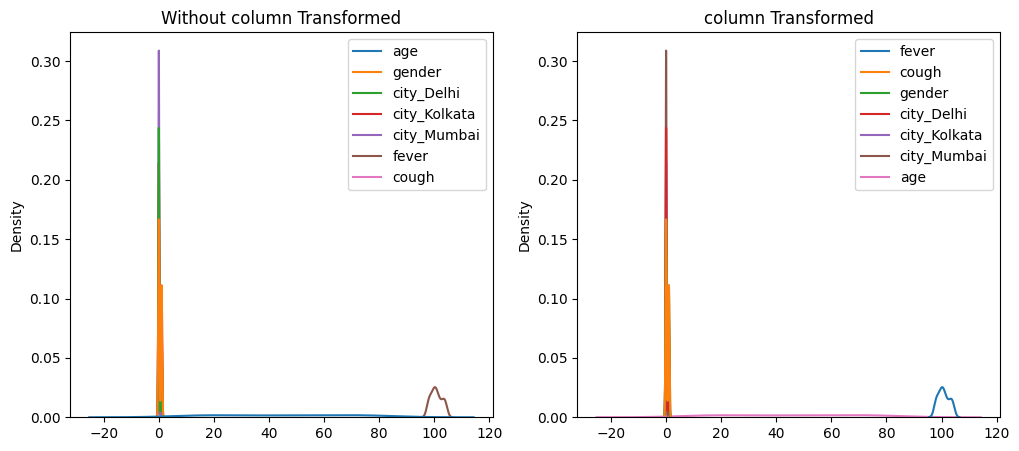

In [156]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# without col transform
ax1.set_title('Without column Transformed')
sns.kdeplot(X_train_transformed,ax=ax1)

#  col transform
ax2.set_title('column Transformed')
sns.kdeplot(X_train_col_transformed,ax=ax2)

plt.show()

In [163]:
#rearranging the columns of data frame

X_train_columns = X_train.columns.values
X_train_transformed = X_train_transformed[X_train_col_transformed.columns.values]

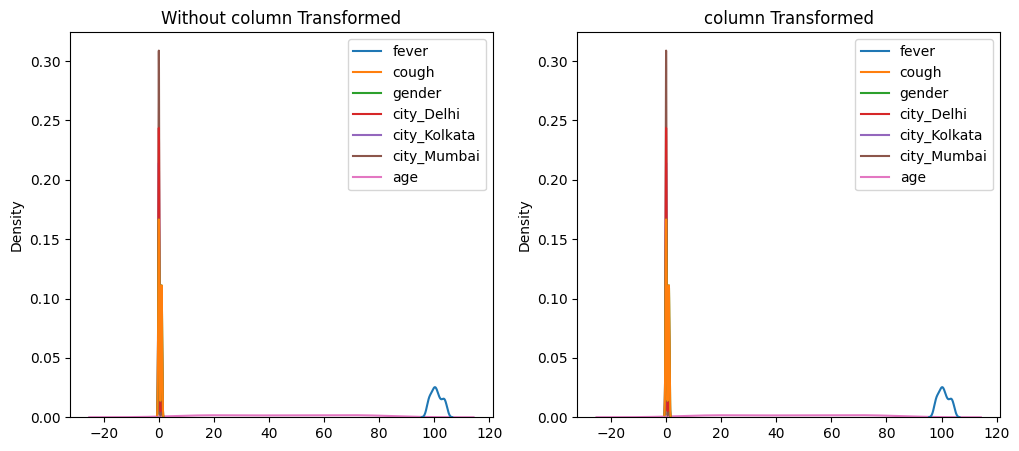

In [164]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# without col transform
ax1.set_title('Without column Transformed')
sns.kdeplot(X_train_transformed,ax=ax1)

#  col transform
ax2.set_title('column Transformed')
sns.kdeplot(X_train_col_transformed,ax=ax2)

plt.show()